# Run-along example
**REQUIREMENTS**: A DAPSYS file containing some sorted spikes
In this example, you will load a DAPSYS file and plot the sorted spikes.

## 1. Create a planner
With planners you can compose your functions and data flow in a directed, acyclic graph (DAG). All planners should implement `openmnglab.model.planning.interface.IExecutionPlanner`.
For ease of use, we will use the `DefaultPlanner` in this example.

In [8]:
from openmnglab.planning import DefaultPlanner

planner = DefaultPlanner()

## 2. Add a source function
To do operations on data, you will first need to ingest data from at least one source function, implementing `ISourceFuntionDefinition`. Classes implementing that interface guarantee that they do not require any input.
In this example, we will load a microneurography recording from a DAPSYS file using the `DapsysReader` function

In [9]:
from pathlib import Path
from openmnglab.functions import DapsysReader

# we will use the pathlib API to define our path. This is generally nicer when working on cross-platform projects, as it is a uniform, platform-independent way to define paths.
# REQUIRED: path to your DAPSYS file
MY_DAPSYS_PATH = Path('.')/'to'/'my'/'dapsys'/'file.dps'

# returns from the DapsysReader module. There is no data behind them, as we haven't executed the plan yet.
continuous_recording, stimuli, tracks, comments, stimulus_definitions = planner.add_source(DapsysReader(MY_DAPSYS_PATH))

Here, we got three returns from the `DapsysReader` function. This returns are proxy data objects - they represent a piece of data that has not yet been calculated. Internally, our `planner` keeps track of the proxy data objects and knows which dataschema is behind each one. This information is used to validate that functions only receive inputs with matching data schemes.

## 3. Execute your plan
Normally, you would first completely build up your analysis flow. But for this example, we will execute it immediately to see if it works

### 3.1 Get your plan
To execute a plan, you will first have to get the plan object:

In [10]:
my_awesome_plan = planner.get_plan()

### 3.2 Create your executor and feed it the plan
To execute a plan, create an object implementing `openmnglab.model.execution.interface.IExecutor` and execute the plan.

A single executor instance may execute multiple plans, while sharing the state of calculated objects between execution runs.

In [11]:
from openmnglab.execution import SingleThreadedExecutor

executor = SingleThreadedExecutor()
executor.execute(my_awesome_plan)

### 3.3 get your data.
You can now use your proxy data tokens to retrieve the computed data containers. A data container implements `openmnglab.model.datamodel.interface.IDataContainer`. The primary data of a data container can always be accessed by the `data` property. Additional properties may be implemented by specific container types. In our case, a `PandasContainer` exposes its pandas data structure through said `data` property, but has the additional `units` property

In [12]:
executor.get(tracks)

PandasContainer @140395669499792
Units: 'global stim id':dimensionless,'track':dimensionless,'track_spike_idx':dimensionless,'spike_ts':s
global stim id  track   track_spike_idx
0               Track2  0                    22.96621
1               Track2  1                    26.96621
2               Track2  2                    30.96611
3               Track2  3                    34.96611
4               Track2  4                    38.96611
                                              ...    
587             Track5  569                2510.96124
588             Track5  570                2514.96094
589             Track5  571                2518.96094
590             Track5  572                2522.96064
592             Track5  573                2530.96084
Name: spike_ts, Length: 1157, dtype: float64

## 4. Add more functions
Now you know how to build and execute a plan and get the data from it. Let's add some more stages to the execution plan.
* To provide input to a normal stage, we pass the proxy data object as simple additional arguments after the function.

In [13]:
import quantities as pq
from openmnglab.functions import Windowing, IntervalData, WaveformPlot

# create a window of +- 1.5 ms around the actionpotential timestamps. Pass a name for the resulting series.
ap_windows = planner.add_stage(Windowing(-1.5 * pq.ms, 1.5 * pq.ms, "ap windows"), tracks)
# now we will extract the data of the windows and calculate their first and second derivatives. This requires the window inervals and the continuous recording
action_potentials = planner.add_stage(IntervalData(0, 1, 2, derivative_base=pq.ms), ap_windows, continuous_recording)
# next, plot the average waveforms of the data with their standard deviation:
action_potential_plots = planner.add_stage(WaveformPlot(), action_potentials)


### 4.1 execute the plan (and the figure)
Executing the plan will calculate and stages and immediately plot the figure when matplotlib is configured using the IPython backend (i.e. when running in Jupyter).

We will re-use the same executor as before. As the previously calculated results of the plan are still present, they can be reused to calculate the new parts of the plan.

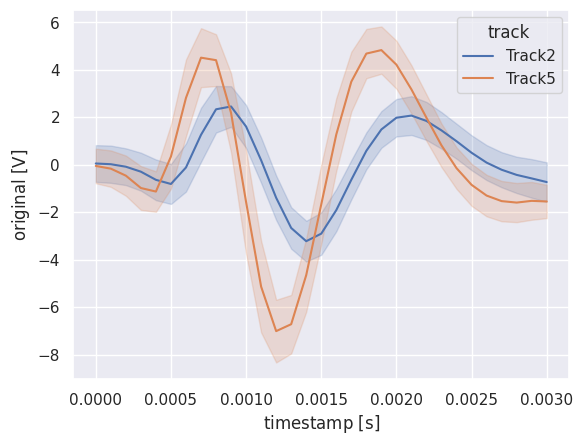

In [14]:
executor.execute(planner.get_plan())

### 4.2 (optional) save the figure
of course, the figure object can still be retrieved from the executor, independent if it was plotted directly or not. To save the figure to a file, retrieve it either by the `data` property of `IDataContainer` or the `figure` attribute of the concrete `MatPlotLibContainer` and save:

In [16]:
executor.get(action_potential_plots).data.savefig("my_actpots.svg")